In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from tensorflow.keras import datasets, layers, utils, Sequential, Model
import matplotlib.pyplot as plt

from utils import *

# Dataset

In [2]:
(train_x, train_y), (test_x, test_y) = datasets.mnist.load_data()
train_x = train_x.reshape([train_x.shape[0], -1]) / 255.
test_x = test_x.reshape([test_x.shape[0], -1]) / 255.

train_y = utils.to_categorical(train_y, 10)
test_y = utils.to_categorical(test_y, 10)

print(train_x.shape, test_x.shape)

(60000, 784) (10000, 784)


# Model

In [3]:
class NN(tf.keras.Model):
    
    def __init__(self, sparsity, inputs_shape= 28 * 28):
        super(NN, self).__init__()
        
        self.sparsity = sparsity
        self.inputs_shape = inputs_shape
        
        self.fc1 = layers.Dense(256, activation="relu", kernel_initializer='glorot_uniform')
        self.fc2 = layers.Dense(128, activation="relu", kernel_initializer='glorot_uniform')
        self.fc3 = layers.Dense(10, activation="softmax", kernel_initializer='glorot_uniform')
        
        self.train_on_sparse = False
    
    def reset_masks(self):
        self.masks = []
        
        for layer in self.layers:        
            w, b = layer.get_weights()
            self.masks.append(tf.ones_like(w))
            self.masks.append(tf.ones_like(b))
        
        return self.masks
    
    def update_masks(self, trainable_vars):

        for i, wb in enumerate(trainable_vars):
            qk = tfp.stats.percentile(tf.math.abs(wb), q = self.sparsity * 100)
            mask = tf.where(tf.math.abs(wb) < qk, 0., 1.)
            # Keep track of masks for "Training on Sparse" step.
            self.masks[i] = mask
    
    def update_wb(self, trainable_vars):
        print("train_on_sparse WB: ACTIVATED")
        for i, (wb, mask) in enumerate(zip(trainable_vars, self.masks)):
            trainable_vars[i].assign(tf.multiply(wb, mask))
   
    def update_gradients(self, gradients):
        print("train_on_sparse GRADIENTS: ACTIVATED")
        for i, (grad, mask) in enumerate(zip(gradients, self.masks)):
            gradients[i] = tf.multiply(grad, mask)                
        
        return gradients

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            
        # Get trainable weights/biases
        trainable_vars = self.trainable_variables
        # Compute gradients
        gradients = tape.gradient(loss, trainable_vars)
        
        # Apply masks.
        if self.train_on_sparse:
            self.update_wb(trainable_vars)
            gradients = self.update_gradients(gradients)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

    def build_model(self):
        x = layers.Input(shape=self.inputs_shape)
        return Model(inputs=[x], outputs = self.call(x))

class UpdateMasks(tf.keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs=None):
        print("ON EPOCH BEGIN: UPDATE MASK")
        trainable_vars = self.model.trainable_variables
        self.model.update_masks(trainable_vars)

Epoch 1/4
1875/1875 [==============================] - 7s 3ms/step - loss: 0.9991 - accuracy: 0.7419
Epoch 2/4
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2973 - accuracy: 0.9154
Epoch 3/4
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2320 - accuracy: 0.9343
Epoch 4/4
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1940 - accuracy: 0.9438


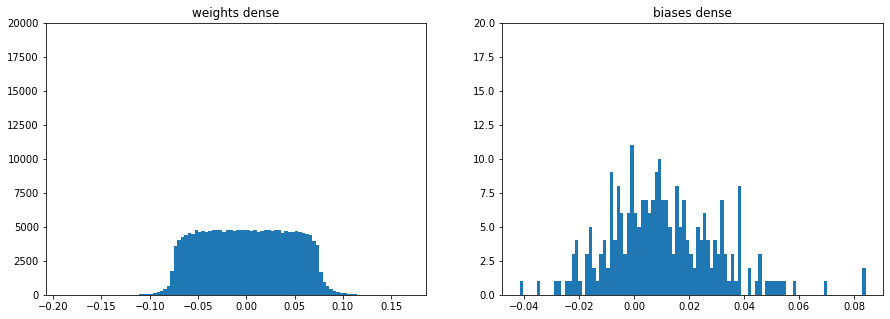

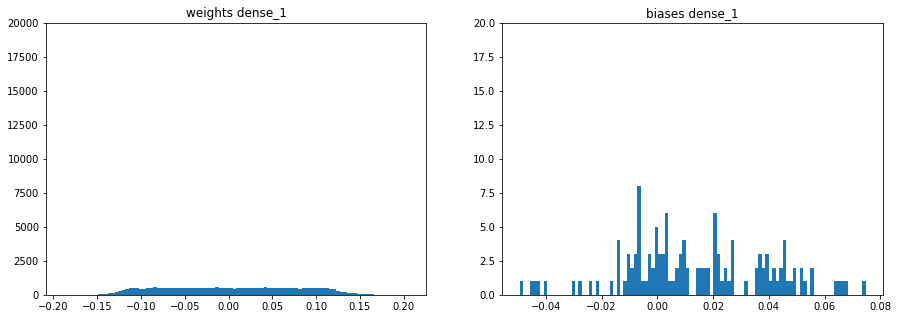

In [4]:
sparsity_global = 0.5
model = NN(sparsity_global)
model.build_model()
model.reset_masks()
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

model.fit(train_x, train_y, epochs=4)
plot_wb(model)

# Train on sparse

In [5]:
model.train_on_sparse = True
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

ON EPOCH BEGIN: UPDATE MASK
train_on_sparse WB: ACTIVATED
train_on_sparse GRADIENTS: ACTIVATED
train_on_sparse WB: ACTIVATED
train_on_sparse GRADIENTS: ACTIVATED
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2000 - accuracy: 0.9448
ON EPOCH BEGIN: UPDATE MASK
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1673 - accuracy: 0.9525
ON EPOCH BEGIN: UPDATE MASK
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1544 - accuracy: 0.9561


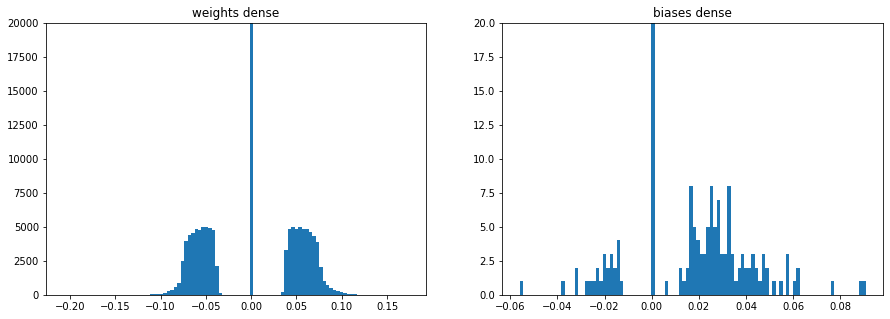

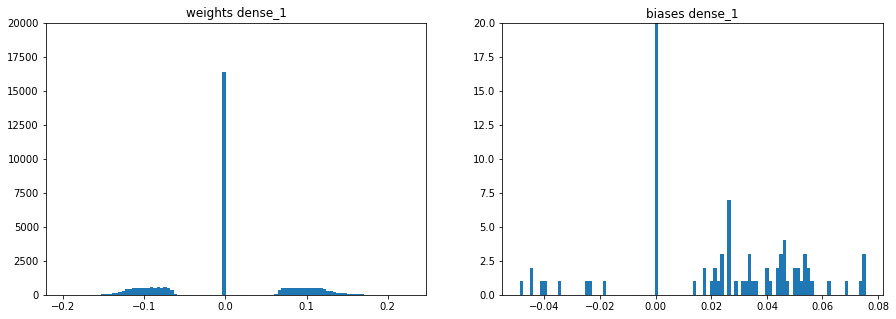

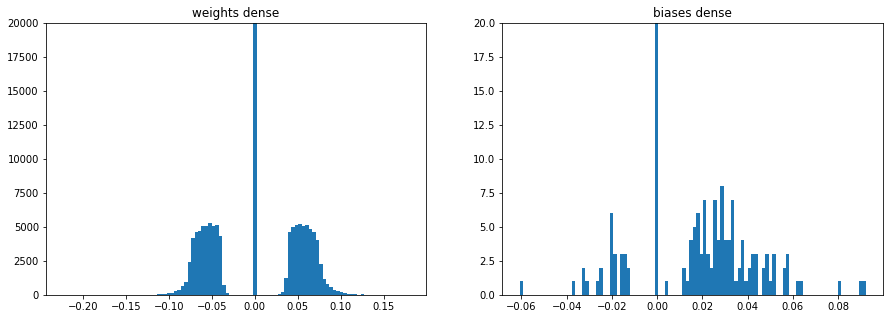

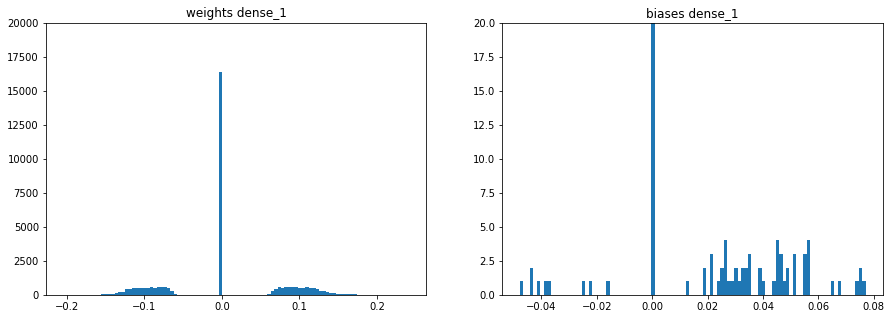

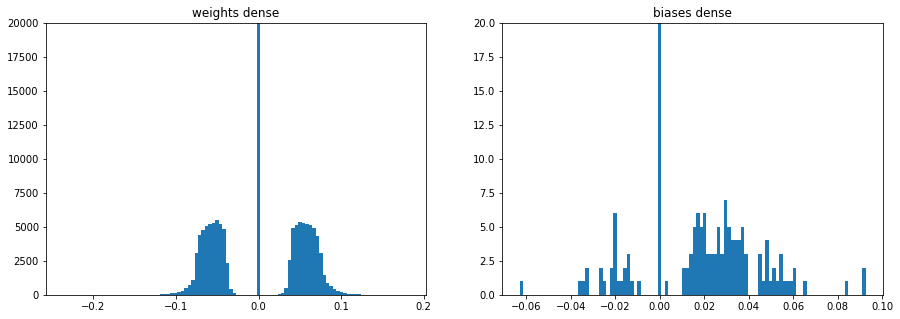

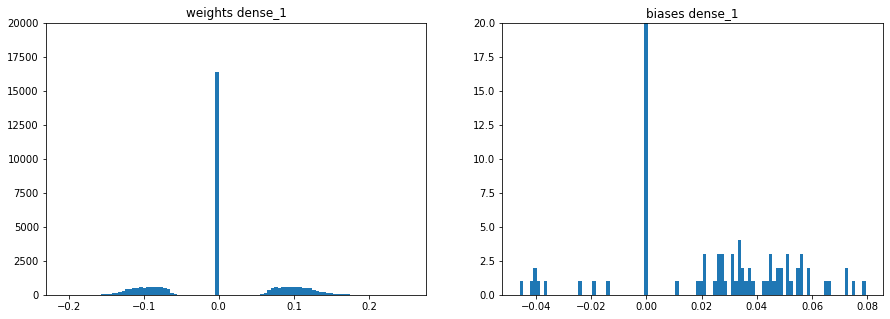

In [6]:
for i in range(3):
    model.fit(train_x, train_y, epochs=1, callbacks=[UpdateMasks()])
    #name = "img/train-on-sparse-epoch-{}.png".format(i)
    #plot_wb_name(model, name)
    plot_wb(model)

In [7]:
wb_non_zero_percentage(model)

Percentage of non-zero value dense: w = 50.0 | b = 50.0


# Retraining

In [8]:
model.train_on_sparse = False
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

1875/1875 [==============================] - 6s 3ms/step - loss: 0.1161 - accuracy: 0.9668


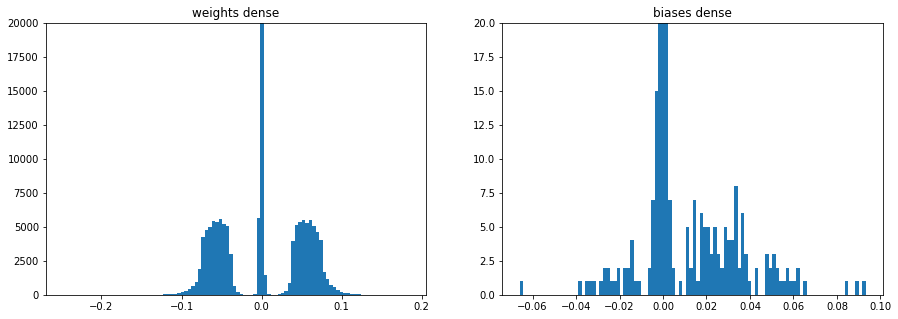

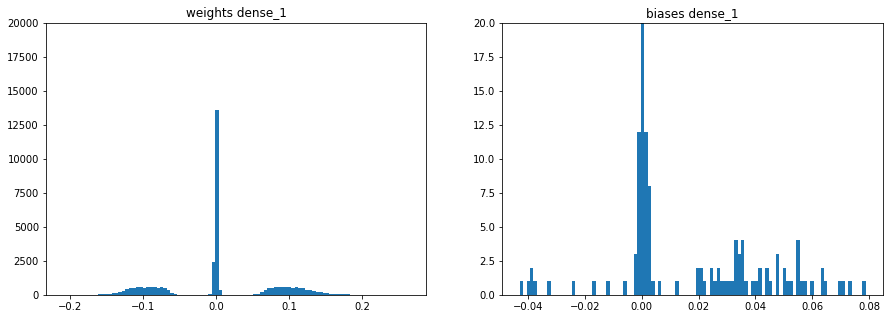

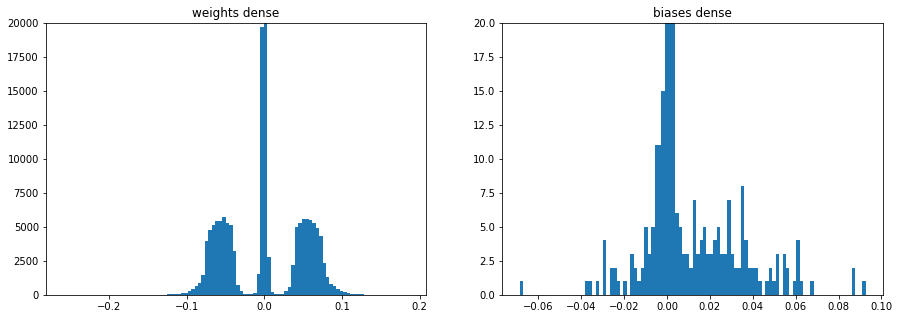

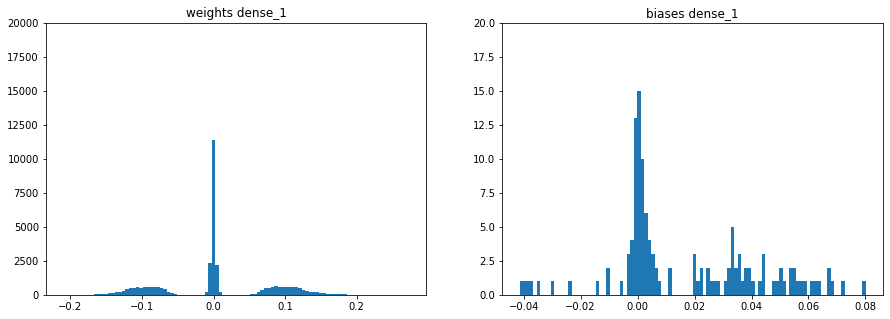

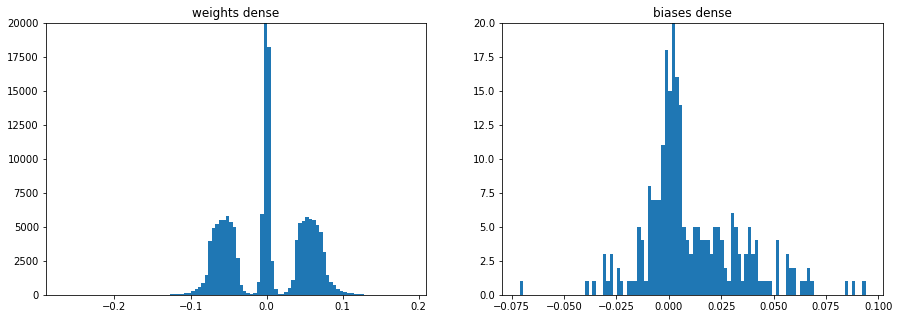

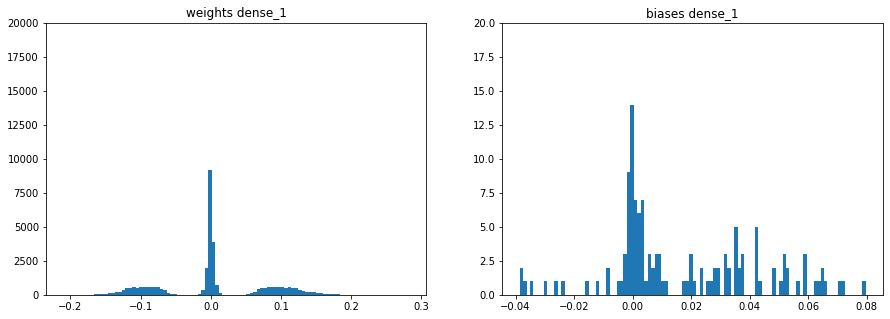

In [9]:
for i in range(3):
    model.fit(train_x, train_y, epochs=1)
    plot_wb(model)

In [10]:
wb_non_zero_percentage(model)

Percentage of non-zero value dense: w = 94.44106744260205 | b = 94.44106744260205
